The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 封闭的经常单位 (GRU)
:label:`sec_gru`

在 :numref:`sec_bptt` 中，我们讨论了如何在 rnN 中计算梯度。特别是我们发现矩阵的长积可能会导致梯度消失或爆炸。让我们简单地考虑一下这种渐变异常在实践中的含义：

* 我们可能会遇到一种情况，即早期观察对于预测未来所有观察都非常重要。考虑一下有些人为的情况，其中第一个观测值包含校验和，目标是识别序列末尾的校验和是否正确。在这种情况下，第一个令牌的影响至关重要。我们希望有一些机制将重要的早期信息存储在 * 内存单元 * 中。如果没有这种机制，我们将不得不为这一观察分配一个非常大的梯度，因为它会影响到随后的所有观察。
* 我们可能会遇到某些代币没有相关观察的情况。例如，在解析网页时，可能会有辅助 HTML 代码，这些代码与评估页面上传达的情绪无关。我们希望有一些机制在潜在状态表示中 * 跳过 * 此类代币。
* 我们可能会遇到序列的各个部分之间有逻辑中断的情况。例如，可能会在书中的章节之间进行过渡，或者证券的熊市和牛市之间的过渡。在这种情况下，最好有一种方法 * 重新设置 * 我们的内部州代表。

为解决这个问题，已经提出了若干方法。最早的一个是长短期记忆 :cite:`Hochreiter.Schmidhuber.1997`，我们将在 :numref:`sec_lstm` 中讨论。门控循环单元 (GRU) :cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` 是一种稍微更精简的变体，通常提供可比的性能，并且计算 :cite:`Chung.Gulcehre.Cho.ea.2014` 的速度要快得多。由于它的简单性，让我们从 GRU 开始。

## 封闭的隐藏状态

香草 rnN 和 gRU 之间的关键区别在于后者支持隐藏状态的门控。这意味着我们有专门的机制来确定隐藏状态何时应该为 * 更新 * 以及何时应该是 * 重置 *。学习了这些机制，它们解决了上述问题。例如，如果第一个令牌非常重要，我们将学会在第一次观察之后不更新隐藏状态。同样，我们将学会跳过无关紧要的临时观察。最后，我们将学习在需要时重置潜在状态。我们在下面详细讨论这个问题。

### 重置 Gate 和更新门

我们需要引入的第一件事是 * 重置门 * 和 * 更新门 *。我们将它们设计成为带有 $(0, 1)$ 条目的向量，以便我们可以执行凸组合。例如，重置门将允许我们控制我们可能仍想记住的以前状态的程度。同样，更新门将允许我们控制新州有多少只是旧状态的副本。

我们首先设计这些门。考虑到当前时间步长的输入和上一个时间步的隐藏状态，:numref:`fig_gru_1` 说明了 GRU 中复位和更新门的输入。两个门的输出由两个带有 sigmoid 激活功能的完全连接层给出。

![Computing the reset gate and the update gate in a GRU model.](../img/gru-1.svg)
:label:`fig_gru_1`

从数学上讲，对于给定时间步长 $t$，假设输入是微型批次 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$（示例数：$n$，输入数量：$d$），前一个时间步长的隐藏状态为 $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$（隐藏单位数：$h$）。然后，重置门 $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 和更新门 $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ 的计算方法如下：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中 $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ 是重量参数，$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ 是偏见。请注意，在总和期间触发广播（见 :numref:`subsec_broadcasting`）。我们使用 sigmoid 函数（如 :numref:`sec_mlp` 中所介绍的那样）将输入值转换为间隔 $(0, 1)$。

### 候选人隐藏状态

接下来，让我们将重置门 $\mathbf{R}_t$ 与 :eqref:`rnn_h_with_state` 中的常规潜在状态更新机制集成起来。它导致以下情况
*候选人隐藏状态 *
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ 在时间步骤 $t$：

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
:eqlabel:`gru_tilde_H`

其中 $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ 是重量参数，$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ 是偏置，符号 $\odot$ 是哈达马德（元素）产品运营商。在这里，我们使用 tanh 形式的非线性来确保候选隐藏状态中的值保持在区间 $(-1, 1)$。

结果是 * 候选人 *，因为我们仍然需要纳入更新门的操作。与 :eqref:`rnn_h_with_state` 相比，现在可以通过 $\mathbf{R}_t$ 和 $\mathbf{H}_{t-1}$ 的元素乘法来降低以前各州的影响力。每当重置门 $\mathbf{R}_t$ 中的条目接近 1 时，我们就会恢复一个香草 RNN，例如 :eqref:`rnn_h_with_state`。对于重置门 $\mathbf{R}_t$ 中接近 0 的所有条目，候选隐藏状态是以 $\mathbf{X}_t$ 作为输入的 MLP 的结果。因此，任何预先存在的隐藏状态都是 * 重置 * 为默认值。

:numref:`fig_gru_2` 说明了应用复位门后的计算流程。

![Computing the candidate hidden state in a GRU model.](../img/gru-2.svg)
:label:`fig_gru_2`

### 隐藏状态

最后，我们需要纳入更新门 $\mathbf{Z}_t$ 的效果。这决定了新的隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ 只是旧状态 $\mathbf{H}_{t-1}$ 的程度，以及新候选状态 $\tilde{\mathbf{H}}_t$ 的使用程度。更新门 $\mathbf{Z}_t$ 可用于此目的，只需在 $\mathbf{H}_{t-1}$ 和 $\tilde{\mathbf{H}}_t$ 之间使用元素凸组合。这将导致 GRU 的最终更新方程式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门 $\mathbf{Z}_t$ 接近 1 时，我们只需保留旧状态。在这种情况下，$\mathbf{X}_t$ 的信息基本上被忽略，实际上跳过了依赖链中的时间步长 $t$。相比之下，只要 $\mathbf{Z}_t$ 接近 0，新的潜在状态 $\mathbf{H}_t$ 就接近候选潜在状态 $\tilde{\mathbf{H}}_t$。这些设计可以帮助我们应对 rnN 中逐渐消失的渐变问题，并更好地捕获具有较长时间步长距离的序列的依赖关系。例如，如果整个子序列的所有时间步长度的更新门都接近 1，则无论子序列的长度如何，其开始时间步的旧隐藏状态都将很容易保留并传递到其末尾。

:numref:`fig_gru_3` 说明了更新门运行之后的计算流程。

![Computing the hidden state in a GRU model.](../img/gru-3.svg)
:label:`fig_gru_3`

总之，GRU 具有以下两个区别特征：

* 重置门有助于捕获顺序中的短期依赖关系。
* 更新门有助于按顺序捕获长期依赖关系。

## 从头开始实施

为了更好地了解 GRU 模型，让我们从头开始实施它。我们首先阅读我们在 :numref:`sec_rnn_scratch` 中使用的时间机器数据集。下面给出了读取数据集的代码。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

正在从http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt下载../data/timemachine.txt...


### 初始化模型参数

下一步是初始化模型参数。我们从标准差的高斯分布中绘制权重为 0.01，然后将偏置设置为 0。超参数 `num_hiddens` 定义了隐藏单位的数量。我们实例化与更新门、重置门、候选隐藏状态和输出层相关的所有权重和偏置。


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

现在我们将定义隐藏状态初始化函数 `init_gru_state`。就像 :numref:`sec_rnn_scratch` 中定义的 `init_rnn_state` 函数一样，此函数返回一个形状（批量大小，隐藏单位数）的张量，其值均为零。


In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

现在我们已经准备好定义 GRU 模型了。它的结构与基本 RNN 单元格的结构相同，只是更新方程更复杂。


In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 训练和预测

培训和预测的工作方式与 :numref:`sec_rnn_scratch` 完全相同。训练后，我们分别在提供的前缀 “时间旅行者” 和 “旅行者” 之后打印训练套装上的困惑和预测顺序。


perplexity 1.1, 24748.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e


travelleryou can show black is white by argument said filby


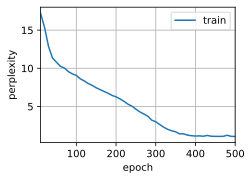

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简明的实施

在高级 API 中，我们可以直接实例化 GPU 模型。这封装了我们在上面明确说明的所有配置细节。该代码要快得多，因为它使用编译的运算符而不是 Python 来解决我们之前拼出的许多细节。


perplexity 1.0, 222994.0 tokens/sec on cuda:0


time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


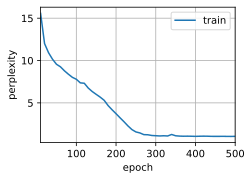

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 摘要

* 封闭的 RNN 可以更好地捕获具有较长时间步长距离的序列的依赖关系。
* 重置门有助于捕获顺序中的短期依赖关系。
* 更新门有助于按顺序捕获长期依赖关系。
* 每当复位门打开时，GRU 都会包含基本的 RNN 作为极端情况。他们还可以通过打开更新门来跳过子序列。

## 练习

1. 假设我们只想使用时间步骤 $t'$ 的输入来预测时间步骤 $t > t'$ 的输出。每个时间步长的重置和更新门的最佳值是什么？
1. 调整超参数并分析它们对运行时间、困惑和输出序列的影响。
1. 比较 `rnn.RNN` 和 `rnn.GRU` 实现的运行时、困惑和输出字符串。
1. 如果只实施 GRU 的一部分（例如，只有重置门或只有更新门），会发生什么情况？


[Discussions](https://discuss.d2l.ai/t/1056)
